# Analysis of 2009 songs

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
!pip install xgboost
import xgboost as xgb
!pip install plotnine
from plotnine import ggplot, aes, geom_point, geom_line, labs
!pip install pyreadr
import pyreadr

In [ ]:
import importlib.metadata as metadata

print('numpy', metadata.version("numpy"))
print('pandas', metadata.version("pandas"))

numpy 1.23.5
pandas 1.5.3


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data processing

In [ ]:
# Read data
data = pyreadr.read_r('song_data.rds')
data = data[None]
print(data.head())

        song_id   tag release_date  release_month release_year  listen_times  \
0     v4hT2a13e   pop   1994-04-10    1994.250000         1994       18775.0   
1   xNgVaKafcd0   pop   2017-09-08    2017.666667         2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333         2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333         2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667         2015       42450.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
0          0.318874   0.128482                0.235004   
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
0                 0.566960      0.355951                 0.075524    0.711590   
1       

In [ ]:
#### Preliminary Checks ####
# Check genre composition over time
data['release_year'] = pd.to_datetime(data['release_date']).dt.year
print(data.head())

data_genres_composition = data.where(data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]))
data_genres_composition = data_genres_composition.dropna(how='all')
# print(data_genres_composition)

# display number of songs for each category for each year
data_genres_composition = data_genres_composition.groupby(['release_year', 'tag']).size().unstack().reset_index().astype(int)
display(data_genres_composition)

# display number of songs for each category and its proportion for each year
visu_data = data_genres_composition.copy()
data_genres_composition['sum'] = data_genres_composition['folk'] + data_genres_composition['hiphop'] + data_genres_composition['pop'] + data_genres_composition['rock']
data_genres_composition['folk_prop'] = data_genres_composition['folk'] / data_genres_composition['sum']
data_genres_composition['hiphop_prop'] = data_genres_composition['hiphop'] / data_genres_composition['sum']
data_genres_composition['pop_prop'] = data_genres_composition['pop'] / data_genres_composition['sum']
data_genres_composition['rock_prop'] = data_genres_composition['rock'] / data_genres_composition['sum']
display(data_genres_composition)

        song_id   tag release_date  release_month  release_year  listen_times  \
0     v4hT2a13e   pop   1994-04-10    1994.250000          1994       18775.0   
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
0          0.318874   0.128482                0.235004   
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
0                 0.566960      0.355951                 0.075524    0.711590   
1 

tag,release_year,folk,hiphop,pop,rock
0,2009,177,54,963,204
1,2010,140,137,1079,227
2,2011,279,113,1023,415
3,2012,289,271,1251,473
4,2013,438,314,1660,564
5,2014,802,804,2432,1211
6,2015,1297,918,2882,1687
7,2016,1072,849,3908,1447
8,2017,1775,2365,6497,2203
9,2018,1902,3636,9687,1940


tag,release_year,folk,hiphop,pop,rock,sum,folk_prop,hiphop_prop,pop_prop,rock_prop
0,2009,177,54,963,204,1398,0.126609,0.038627,0.688841,0.145923
1,2010,140,137,1079,227,1583,0.088440,0.086545,0.681617,0.143399
2,2011,279,113,1023,415,1830,0.152459,0.061749,0.559016,0.226776
3,2012,289,271,1251,473,2284,0.126532,0.118651,0.547723,0.207093
4,2013,438,314,1660,564,2976,0.147177,0.105511,0.557796,0.189516
5,2014,802,804,2432,1211,5249,0.152791,0.153172,0.463326,0.230711
6,2015,1297,918,2882,1687,6784,0.191185,0.135318,0.424823,0.248673
7,2016,1072,849,3908,1447,7276,0.147334,0.116685,0.537108,0.198873
8,2017,1775,2365,6497,2203,12840,0.138240,0.184190,0.505997,0.171573
9,2018,1902,3636,9687,1940,17165,0.110807,0.211826,0.564346,0.113021


## Data visualization

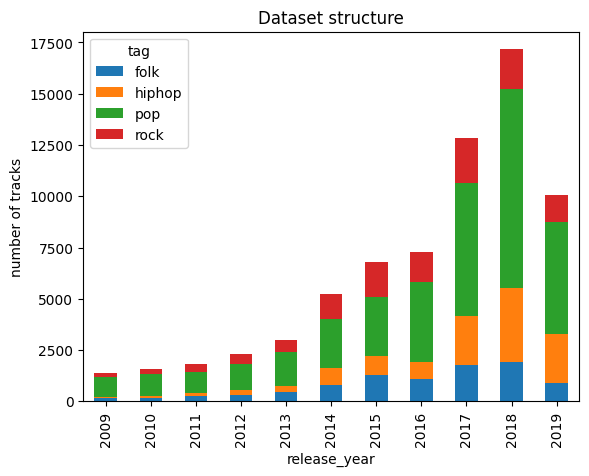

In [ ]:
ax = visu_data.plot.bar(x='release_year', stacked=True)
plt.ylabel('number of tracks')
plt.title('Dataset structure')
plt.show()

# Machine learning training set preparation

In [ ]:
# Group by tag and select top 50 listened songs of 2009
# ml_data_pop = data[(data['tag'] == 'pop') & (data['release_year'] == '2009')].nlargest(50, 'listen_times') # 50 first most listened for each genre
# ml_data_hiphop = data[(data['tag'] == 'hiphop') & (data['release_year'] == '2009')].nlargest(50, 'listen_times')
# ml_data_rock = data[(data['tag'] == 'rock') & (data['release_year'] == '2009')].nlargest(50, 'listen_times')
# ml_data_folk = data[(data['tag'] == 'folk') & (data['release_year'] == '2009')].nlargest(50, 'listen_times')
# ml_data = pd.concat([ml_data_pop, ml_data_hiphop, ml_data_rock, ml_data_folk], axis=0)

ml_data = data.copy()[data['release_year'] == 2009]
ml_data = ml_data.groupby('tag').apply(lambda x: x.nlargest(50, 'listen_times')).reset_index(drop=True)

print(ml_data.head())
print(ml_data.size)

# Split data into train and test sets
ml_train, ml_test = train_test_split(ml_data, test_size=0.2, random_state=210016, shuffle=True)

# Select features for training and testing
ml_train = ml_train.iloc[:, [1] + list(range(6, 17))]
ml_test = ml_test.iloc[:, [1] + list(range(6, 17))]

y_true = ml_test['tag'].to_numpy()
y_true = np.unique(y_true, return_inverse=True)[1]

        song_id   tag release_date  release_month  release_year  listen_times  \
0    esQzo50232  folk   2009-03-24    2009.166667          2009     8078141.0   
1   mQ3QCo8ef09  folk   2009-08-25    2009.583333          2009     7848261.0   
2    bART510ddb  folk   2009-02-01    2009.083333          2009     3776846.0   
3  b1pMIuu3c9a8  folk   2009-08-25    2009.583333          2009     1945089.0   
4    cWV491e251  folk   2009-03-24    2009.166667          2009     1718725.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
0          0.311116   0.144829                0.293724   
1          0.240696   0.175462                0.204968   
2          0.320236   0.151201                0.317283   
3          0.288632   0.201726                0.304672   
4          0.298561   0.271811                0.340062   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
0                 0.664422      0.544815                 0.089355    0.707437   
1 

# Train classifiers

## Naive Bayes

In [ ]:
nb_model = GaussianNB()
# fit data to model
nb_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
p_train = nb_model.predict(ml_train.iloc[:, 1:])
p_train_prob = nb_model.predict_proba(ml_train.iloc[:, 1:])
print('Mean on training set of NB ', round(np.mean(p_train == ml_train.iloc[:, 0]),3))

# predict proba from test
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
print('Mean on test set of NB', round(np.mean(p_test == ml_test.iloc[:, 0]),3))

# compute ROC AUC score of test set
print('AUC score of NB', round(roc_auc_score(y_true, p_test_prob, multi_class='ovr'),3))

Mean on training set of NB  0.575
Mean on test set of NB 0.6
AUC score of NB 0.821


## K-Nearest Neighbors

In [ ]:
# # Use AUC to find the best k: 31
# # Init dataframe and columns
df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
for k in range(1, 41):
    #print(k)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
    knn_model_prob = knn_model.predict_proba(ml_test.iloc[:, 1:])
    y_pred_lab = knn_model.predict(ml_test.iloc[:, 1:])
    acc = np.mean(y_pred_lab == ml_test.iloc[:, 0])
    auc = roc_auc_score(y_true, knn_model_prob, multi_class='ovr')
    # df_knn_auc = df_knn_auc.append({'k': k, 'acc': acc, 'auc': auc}, ignore_index=True)
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
df_knn_auc = df_knn_auc.sort_values(by='acc', ascending=False)
display(df_knn_auc.head())

# df_knn_auc = pd.DataFrame(columns=['k', 'acc', 'auc'])
# for k in range(1, 20):
#     knn_model = KNeighborsClassifier(n_neighbors=k)
#     knn_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
#     knn_pred = knn_model.predict(ml_test.iloc[:, 1:])
#     acc = sum(knn_pred == ml_test.iloc[:, 0]) / len(knn_pred)
#     auc = roc_auc_score(ml_test.iloc[:, 0], knn_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
#     df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame.from_records([{'k': k, 'acc': acc, 'auc': auc}])])
#     print(k)
# df_knn_auc = df_knn_auc.sort_values(['acc','auc'], ascending=[False,False]).head(10)
# print('KNN AUC score :\n', df_knn_auc)

,k,acc,auc
0,28,0.625,0.836879
0,26,0.625,0.845904
0,25,0.625,0.839248
0,13,0.625,0.803032
0,27,0.600,0.839009


## Random Forest

In [ ]:
# init dataframe and columns
df_rf_auc = pd.DataFrame(columns=['n', 'max', 'acc', 'auc'])
for n in range(20, 41):
    for max in range(20, 41):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train.iloc[:, 0])
        rf_model_prob = rf_model.predict_proba(ml_test.iloc[:, 1:])
        acc = np.mean(rf_model.predict(ml_test.iloc[:, 1:]) == ml_test.iloc[:, 0])
        auc = roc_auc_score(y_true, rf_model_prob, multi_class='ovr')
        # df_rf_auc = df_rf_auc.append({'n': n, 'max': max, 'acc': acc, 'auc': auc}, ignore_index=True)
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame.from_records([{'n': n, 'max': max, 'acc': acc, 'auc': auc}])])
        print('depth :',max)
    print('n :',n)
df_rf_auc = df_rf_auc.sort_values(by='acc', ascending=False)
display(df_rf_auc.head())

depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 20
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 21
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 22
depth : 20
depth : 21
depth : 22
depth : 23
depth : 24
depth : 25
depth : 26
depth : 27
depth : 28
depth : 29
depth : 30
depth : 31
depth : 32
depth : 33
depth : 34
depth : 35
depth : 36
depth : 37
depth : 38
depth : 39
depth : 40
n : 23
depth : 20
depth : 21
depth : 22
depth : 23
dept

,n,max,acc,auc
0,29,29,0.675,0.815832
0,24,39,0.675,0.848662
0,39,25,0.675,0.830115
0,29,32,0.650,0.806721
0,32,36,0.650,0.834454


## XGBoost

In [ ]:
ml_train_num = ml_train.copy()
ml_train_num['tag'] = ml_train_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
ml_test_num = ml_test.copy()
ml_test_num['tag'] = ml_test_num['tag'].replace({'pop': 0, 'hiphop': 1, 'rock': 2, 'folk': 3})
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num.iloc[:, 0])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num.iloc[:, 0])
best_param = {'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 4}
best_seednumber = 1234
best_logloss = float('inf')
best_logloss_index = 0
print('training')
# train on 10 epochs
for iter in range(1, 1000):
    print('epoch',iter)
    param = best_param.copy()
    param['max_depth'] = np.random.randint(2, 6)
    param['eta'] = np.random.uniform(0.01, 0.3)
    seed_number=np.random.randint(10000)
    cv_result = xgb.cv(params=param, dtrain=train_matrix, num_boost_round=1000, nfold=5, early_stopping_rounds=8, seed=seed_number)
    min_logloss = cv_result['test-mlogloss-mean'].min()
    min_logloss_index = cv_result['test-mlogloss-mean'].idxmin()
    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number

nround = best_logloss_index
bst_model = xgb.train(params=best_param, dtrain=train_matrix, num_boost_round=nround)
# Predict hold-out test set
test_pred = bst_model.predict(test_matrix)
test_prediction = pd.DataFrame(test_pred).apply(lambda x: np.argmax(x), axis=1)
print('Mean on test set with XGB boost is', round(np.mean(test_prediction.to_numpy() == ml_test_num.iloc[:, 0].to_numpy()),3))
print('AOC score on test set with XGB boost is', round(roc_auc_score(y_true, test_pred, multi_class='ovr'),3))

training
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110

# Prediction

In [ ]:
data_predict = data[data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])]
data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date']).dt.year
data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['treatment_date'] = (pd.to_datetime(data_predict['release_date']) < pd.to_datetime('2017-06-24'))
data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
print(data_predict.head())
# data_predict = data.copy()[data['release_year'].isin([2009, '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
# data_predict['release_year'] = pd.to_datetime(data_predict['release_date']).dt.year
# data_predict['tag_bin'] = data_predict['tag'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
# data_predict['treatment_date'] = (pd.to_datetime(data_predict['release_date']) < pd.to_datetime('2017-04-16'))
# data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
# print(data_predict.head())
x_data_predict = data_predict.iloc[:, 6:17]


        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-33-cc98150a0bb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-33-cc98150a0bb6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-33-cc98150a0bb6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-33-cc98150a0bb6>

## Naive Bayes

In [ ]:
data_predict.loc[:,'gnb_pred'] = nb_model.predict(data_predict.iloc[:, 6:17])
data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
data_predict.loc[:,'gnb_pred_bin'] = np.where(data_predict['gnb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'gnb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['gnb_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-34-dc519c189e67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-34-dc519c189e67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-34-dc519c189e67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-34-dc519c189e67>

## K-Nearest Neighbors

In [ ]:
data_predict['knn_pred'] = knn_model.predict(data_predict.iloc[:, 6:17])
data_predict['knn_pred_acc'] = (data_predict['knn_pred'] == data_predict['tag']).astype(int)
data_predict['knn_pred_bin'] = np.where(data_predict['knn_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['knn_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['knn_pred_bin']).astype(int)
data_predict = data_predict.dropna(how='all')
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

<ipython-input-35-7451536712c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-35-7451536712c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-35-7451536712c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-35-7451536712c6>

## Random Forest

In [ ]:
data_predict['rf_pred'] = rf_model.predict(data_predict.iloc[:, 6:17])
data_predict['rf_pred_acc'] = data_predict['rf_pred'] == data_predict['tag']
data_predict['rf_pred_bin'] = np.where(data_predict['rf_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['rf_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['rf_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

## XGBoost

In [ ]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(data_predict.iloc[:, 6:17]))
#data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: np.argmax(x) + 1, axis=1)
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).idxmax(axis=1)
data_predict['xgb_pred'] = data_predict['xgb_pred'].replace({0: 'pop', 1: 'hiphop', 2: 'rock', 3: 'folk'})
data_predict['xgb_pred_acc'] = data_predict['xgb_pred'] == data_predict['tag']
data_predict['xgb_pred_bin'] = np.where(data_predict['xgb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict['xgb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['xgb_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
1                 0.570343      0.463045                 0.159881    0.802928   
2 

In [ ]:
# print(data_predict)
print(data_predict.columns)
data_predict.to_pickle('pickles/data_predict_2009.pkl')

Index(['song_id', 'tag', 'release_date', 'release_month', 'release_year',
       'listen_times', 'chroma_stft_norm', 'rmse_norm',
       'spectral_centroid_norm', 'spectral_bandwidth_norm', 'rolloff_norm',
       'zero_crossing_rate_norm', 'mfcc1_norm', 'mfcc2_norm', 'mfcc3_norm',
       'mfcc4_norm', 'mfcc5_norm', 'mfcc6_norm', 'mfcc7_norm', 'mfcc8_norm',
       'mfcc9_norm', 'mfcc10_norm', 'mfcc11_norm', 'mfcc12_norm',
       'mfcc13_norm', 'mfcc14_norm', 'mfcc15_norm', 'mfcc16_norm',
       'mfcc17_norm', 'mfcc18_norm', 'mfcc19_norm', 'mfcc20_norm', 'tag_bin',
       'treatment_date', 'treatment_year', 'gnb_pred', 'gnb_pred_acc',
       'gnb_pred_bin', 'gnb_pred_bin_acc', 'knn_pred', 'knn_pred_acc',
       'knn_pred_bin', 'knn_pred_bin_acc', 'rf_pred', 'rf_pred_acc',
       'rf_pred_bin', 'rf_pred_bin_acc', 'xgb_pred', 'xgb_pred_acc',
       'xgb_pred_bin', 'xgb_pred_bin_acc'],
      dtype='object')


# Metrics

## Naive Bayes

In [ ]:
###### Mean Prediction 4 Tags Accuracy By Years ######
gnb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
gnb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
###### Prediction Hip-Hop Recall By Years ######
gnb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
###### Prediction Hip-Hop Precision By Years ######
gnb_precision_tbyyear    = data_predict.copy()[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics.head())
print(gnb_metrics.columns)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(gnb_metrics.head())

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,1,0.366237,0.842632,0.629630,0.145299
1,2010,1,0.392925,0.792798,0.335766,0.162544
2,2011,1,0.377049,0.802186,0.292035,0.104762
3,2012,1,0.439142,0.802102,0.346863,0.254743
4,2013,1,0.375336,0.800739,0.414013,0.241187


Index(['release_year', 'treatment_year', 'gnb_pred_acc', 'gnb_pred_bin_acc',
       'gnb_recall', 'gnb_precision'],
      dtype='object')


,release_year,treatment_year,metrics,values
0,2009,1,gnb_pred_acc,0.366237
1,2010,1,gnb_pred_acc,0.392925
2,2011,1,gnb_pred_acc,0.377049
3,2012,1,gnb_pred_acc,0.439142
4,2013,1,gnb_pred_acc,0.375336


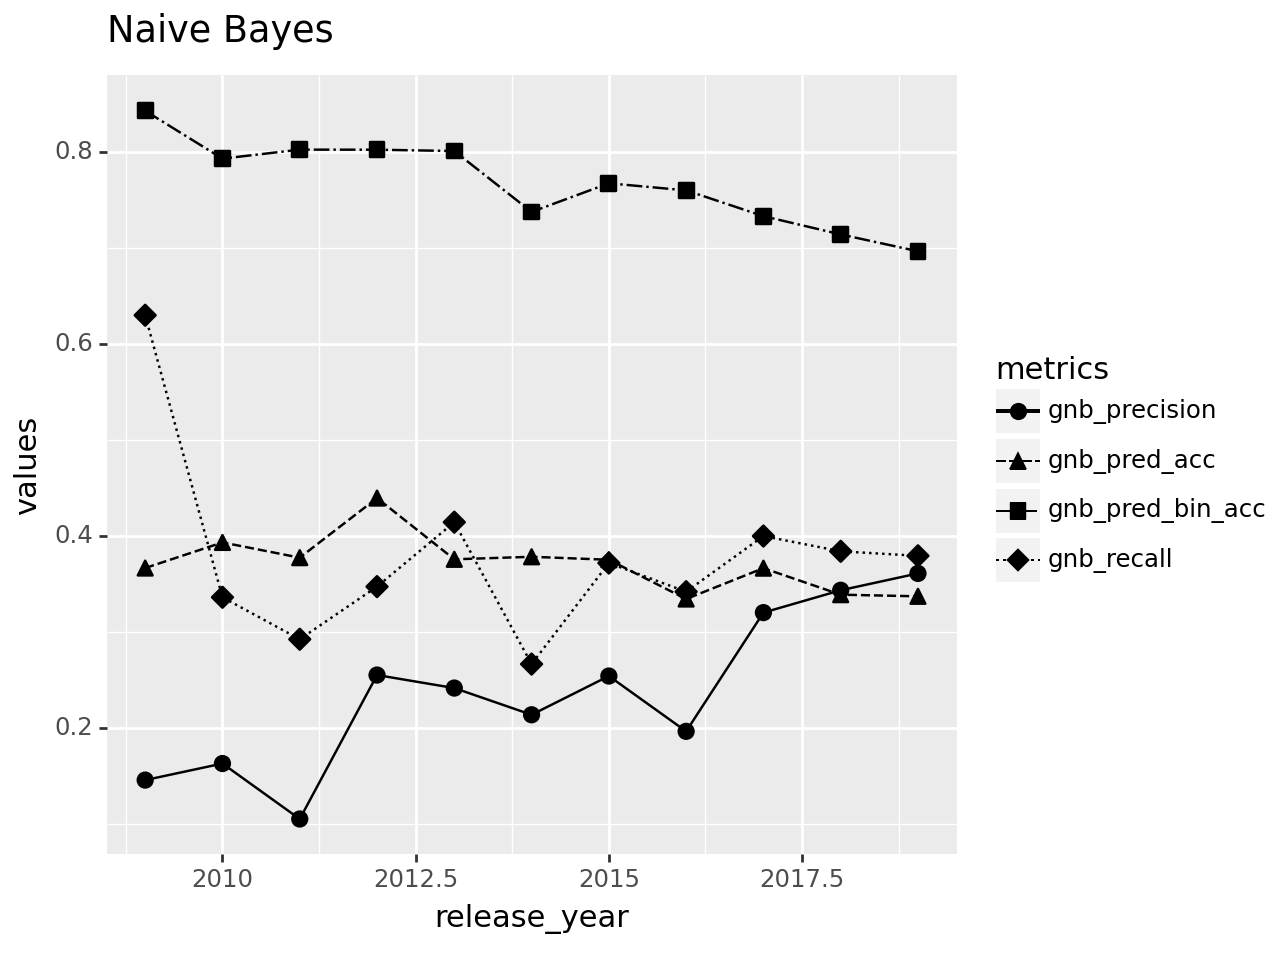

In [ ]:
# plot results
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Naive Bayes") + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_2009.pkl')

## K-Nearest Neighbors

   release_year  treatment_year  knn_pred_acc
0          2009               1      0.419170
1          2010               1      0.442830
2          2011               1      0.409290
3          2012               1      0.466287
4          2013               1      0.421707
   release_year  treatment_year  knn_pred_bin_acc
0          2009               1          0.865522
1          2010               1          0.829438
2          2011               1          0.822951
3          2012               1          0.800788
4          2013               1          0.814852


,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,1,0.419170,0.865522,0.629630,0.168317
1,2010,1,0.442830,0.829438,0.430657,0.235060
2,2011,1,0.409290,0.822951,0.362832,0.139932
3,2012,1,0.466287,0.800788,0.376384,0.262887
4,2013,1,0.421707,0.814852,0.388535,0.253638


,release_year,treatment_year,metrics,values
0,2009,1,knn_pred_acc,0.419170
1,2010,1,knn_pred_acc,0.442830
2,2011,1,knn_pred_acc,0.409290
3,2012,1,knn_pred_acc,0.466287
4,2013,1,knn_pred_acc,0.421707


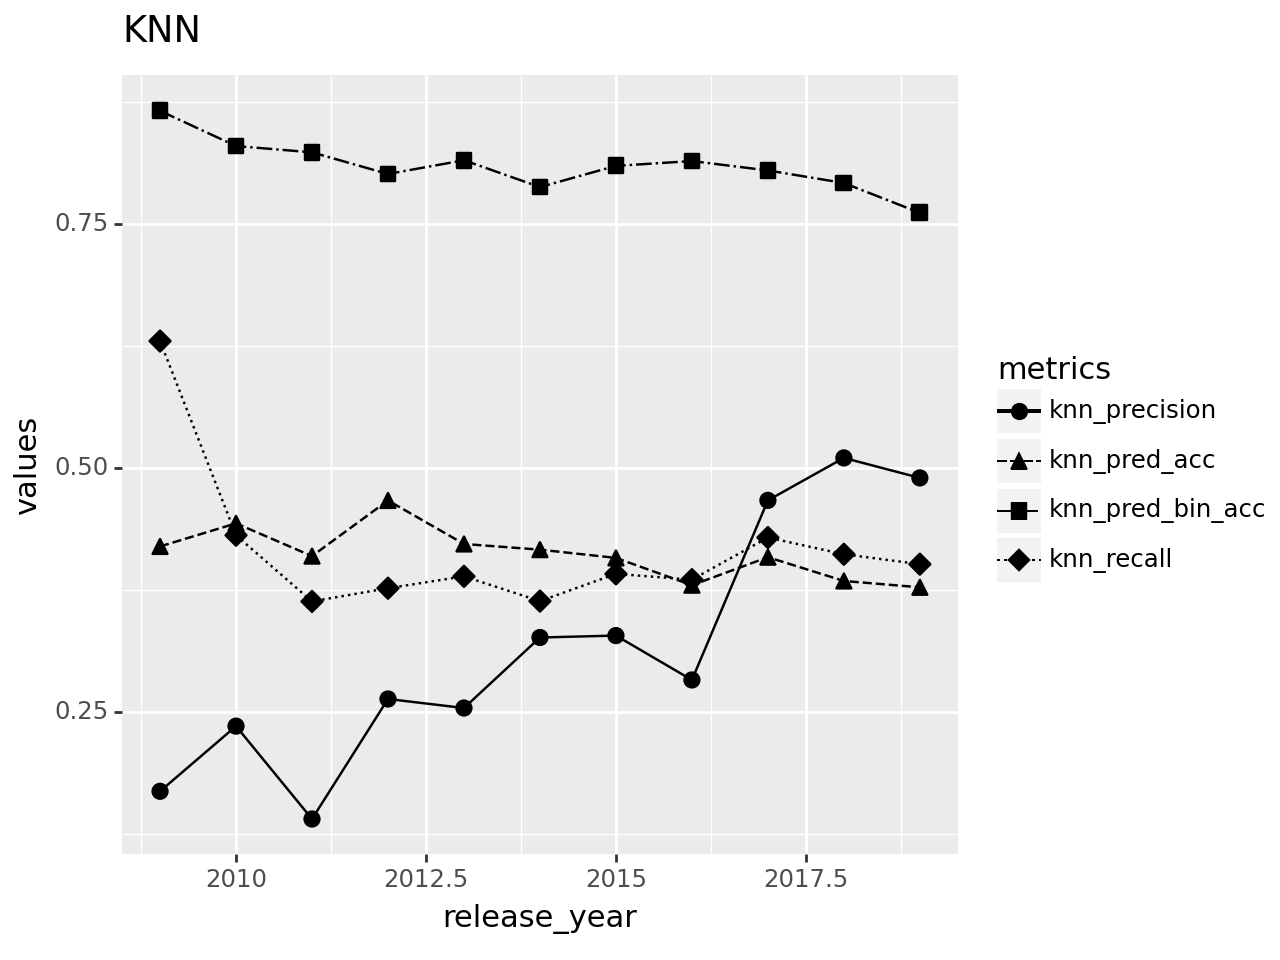

In [ ]:
###### Mean Prediction 4 Tags Accuracy By Years ######
knn_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
print(knn_mean_acc_tbyyear.head())
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
knn_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
print(knn_mean_bin_acc_tbyyear.head())
# print(data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index())

###### Prediction Hip-Hop Recall By Years ######
knn_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
# print(knn_recall_tbyyear)
###### Prediction Hip-Hop Precision By Years ######
knn_precision_tbyyear = data_predict[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics.head())

knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(knn_metrics.head())

# plot results
knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="KNN") + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_2009.pkl')


## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,1,0.429185,0.874821,0.907407,0.223744
1,2010,1,0.394820,0.830069,0.562044,0.269231
2,2011,1,0.385246,0.819672,0.548673,0.181818
3,2012,1,0.422067,0.815236,0.516605,0.324826
4,2013,1,0.380376,0.814852,0.573248,0.301508
5,2014,1,0.393218,0.783578,0.493781,0.352575
6,2015,1,0.400796,0.811321,0.550109,0.368076
7,2016,1,0.376306,0.799340,0.542992,0.300718
8,2017,0,0.405296,0.807321,0.602960,0.481594
9,2018,0,0.396155,0.797437,0.615237,0.518424


,release_year,treatment_year,metrics,values
0,2009,1,rf_pred_acc,0.429185
1,2010,1,rf_pred_acc,0.394820
2,2011,1,rf_pred_acc,0.385246
3,2012,1,rf_pred_acc,0.422067
4,2013,1,rf_pred_acc,0.380376
5,2014,1,rf_pred_acc,0.393218
6,2015,1,rf_pred_acc,0.400796
7,2016,1,rf_pred_acc,0.376306
8,2017,0,rf_pred_acc,0.405296
9,2018,0,rf_pred_acc,0.396155


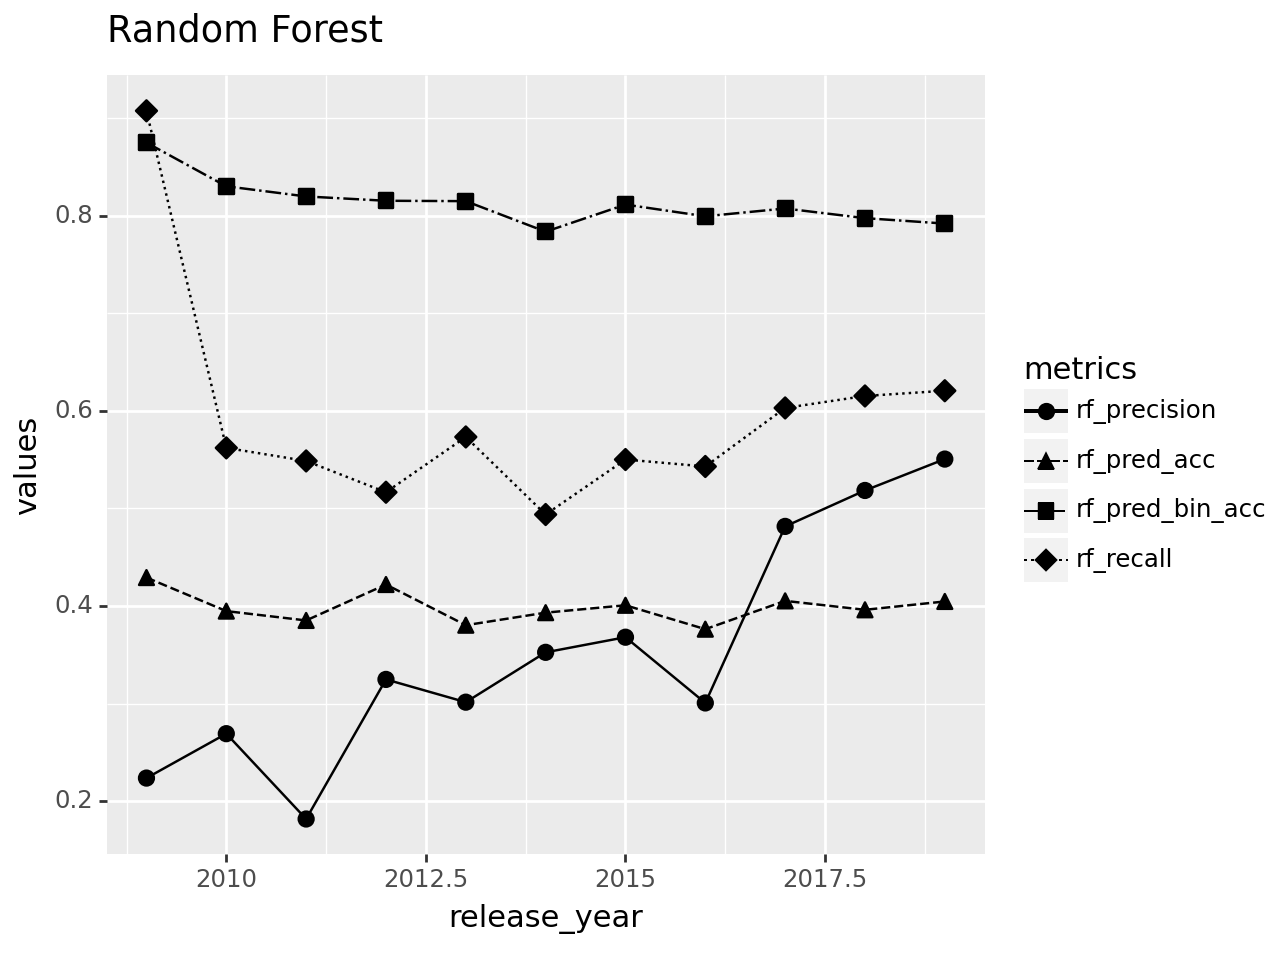

In [ ]:
###### Mean Prediction 4 Tags Accuracy By Years ######
rf_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
rf_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
###### Prediction Hip-Hop Recall By Years ######
rf_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
###### Prediction Hip-Hop Precision By Years ######
rf_precision_tbyyear    = data_predict.copy()[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(rf_metrics)
# plot metrics
rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Random Forest") + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_2009.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,1,0.215308,0.803290,0.092593,0.021645
1,2010,1,0.212255,0.768162,0.131387,0.067669
2,2011,1,0.224590,0.791803,0.141593,0.053333
3,2012,1,0.184764,0.758319,0.121771,0.095101
4,2013,1,0.204637,0.765457,0.098726,0.069507


,release_year,treatment_year,metrics,values
0,2009,1,xgb_pred_acc,0.215308
1,2010,1,xgb_pred_acc,0.212255
2,2011,1,xgb_pred_acc,0.224590
3,2012,1,xgb_pred_acc,0.184764
4,2013,1,xgb_pred_acc,0.204637


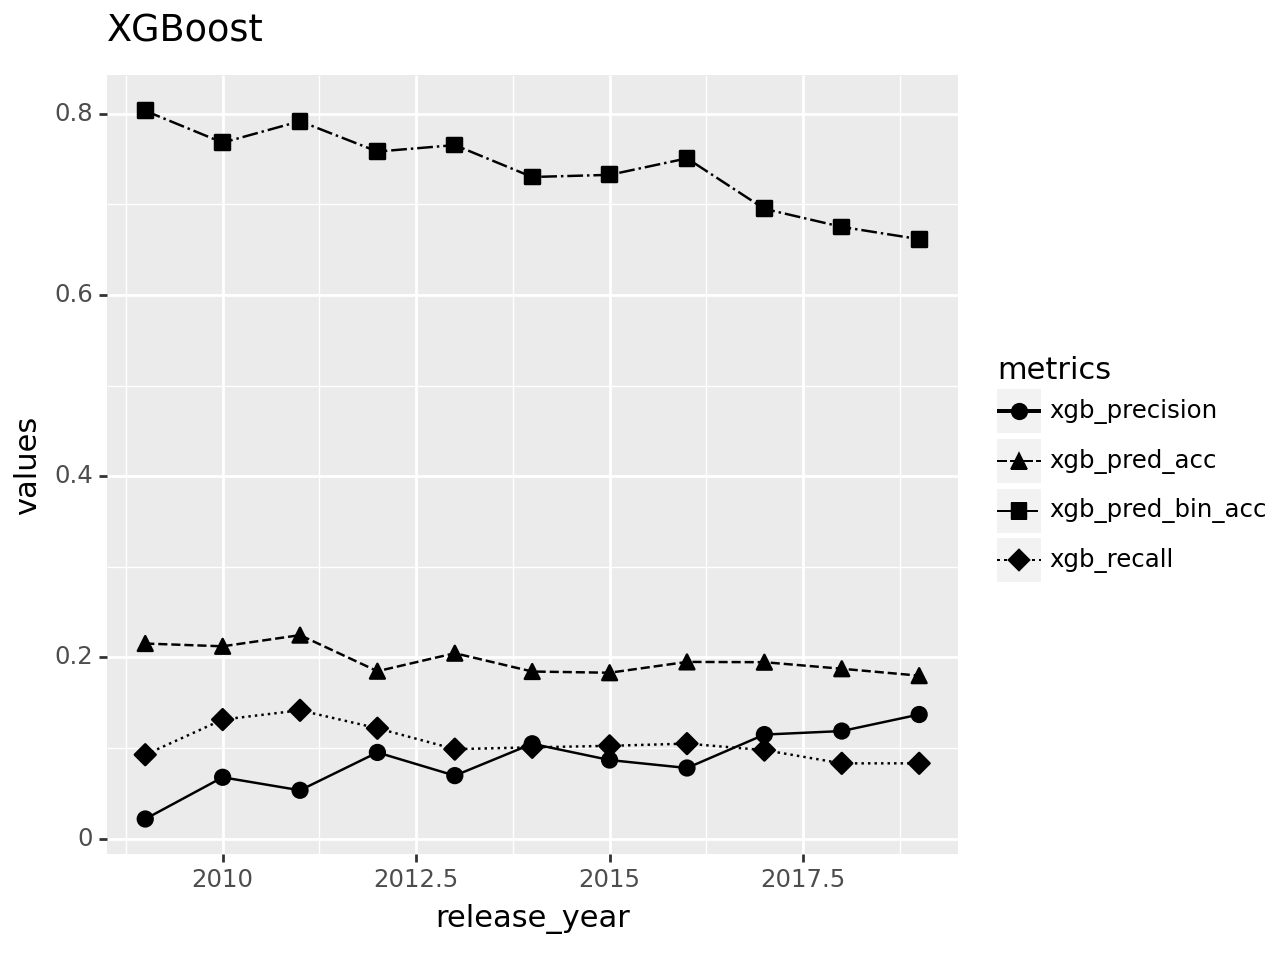

In [ ]:
###### Mean Prediction 4 Tags Accuracy By Years ######
xgb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
###### Mean Prediction Hip-Hop Binary Accuracy By Years ######
xgb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
###### Prediction Hip-Hop Recall By Years ######
xgb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
###### Prediction Hip-Hop Precision By Years ######
xgb_precision_tbyyear    = data_predict.copy()[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
###### Aggregating Graphics: Mean Acc, Mean Hip-Hop Acc, Trap, Non-Trap ######
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics.head())
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
display(xgb_metrics.head())
# Plot graphics
xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="XGBoost") + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_2009.pkl')

## Average Four Classifiers

,release_year,treatment_year,metrics,values
0,2009,1,classifiers_pred_acc,0.357475
1,2010,1,classifiers_pred_acc,0.360708
2,2011,1,classifiers_pred_acc,0.349044
3,2012,1,classifiers_pred_acc,0.378065
4,2013,1,classifiers_pred_acc,0.345514
5,2014,1,classifiers_pred_acc,0.342875
6,2015,1,classifiers_pred_acc,0.341539
7,2016,1,classifiers_pred_acc,0.321193
8,2017,0,classifiers_pred_acc,0.343575
9,2018,0,classifiers_pred_acc,0.326478


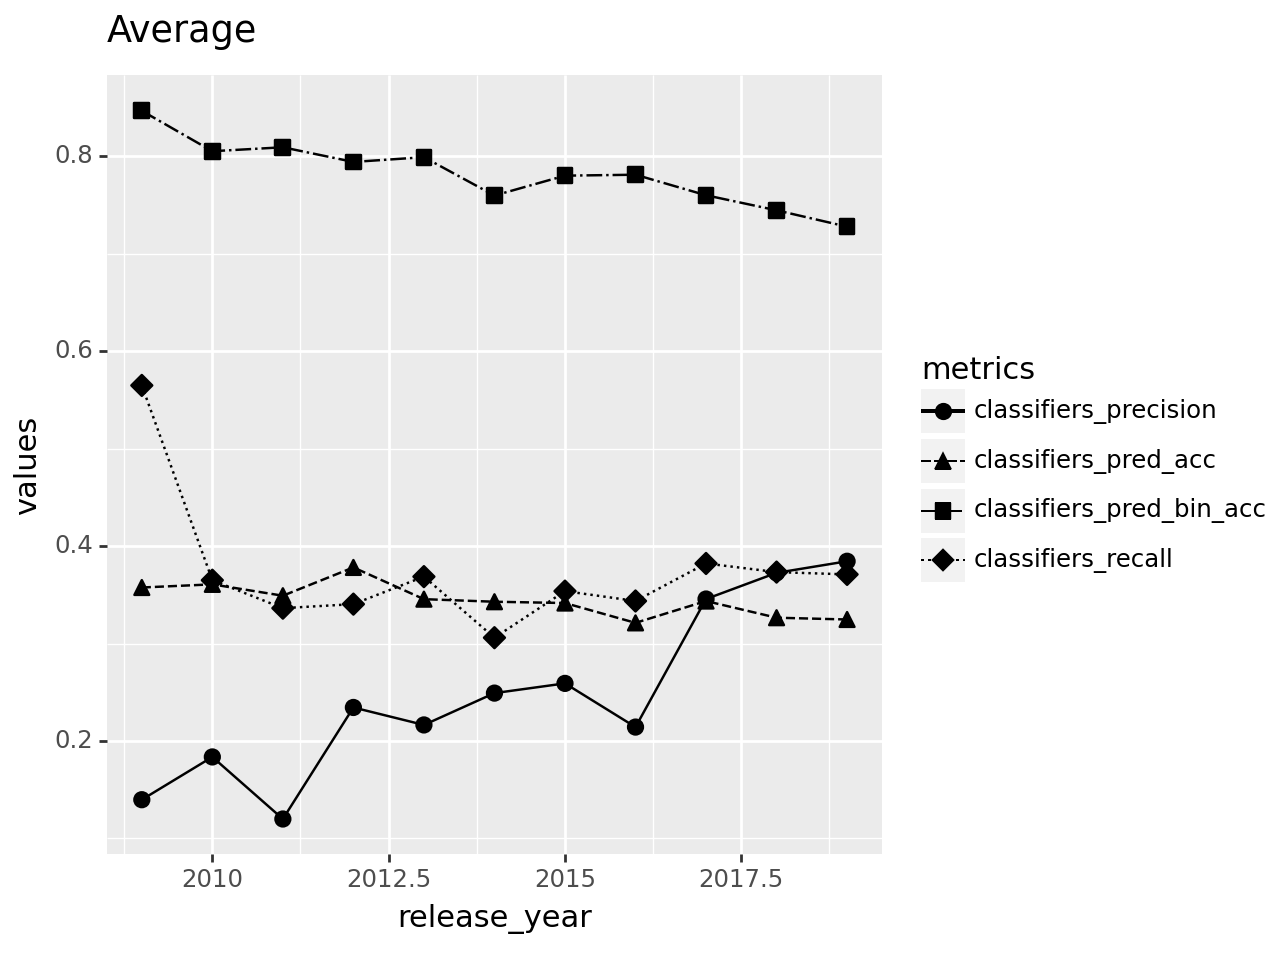

In [ ]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_2009.pkl')
display(average)
# Display Metrics
average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + labs(title="Average") + geom_line(aes(linetype='metrics'))
print(average_plot)